In [1]:
from numbers_parser import Document
import pandas as pd
import glob,os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.optimize import minimize

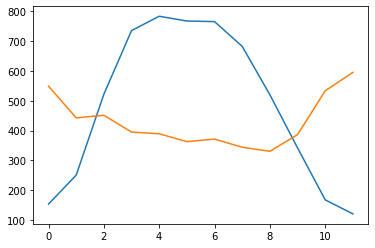

In [2]:
estimate=np.array([154,251,522,735,783,767,765,682,520,342,168,121])
used_2022=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
plt.plot(estimate)
plt.plot(used_2022)

In [3]:
y=2022
months=np.arange(1,13)

first_day_of_month=[datetime(y,m,1) for m in months]
last_day_of_month=[datetime(y,m+1,1)-timedelta(days=1) for m in months[:-1]]+[datetime(y+1,1,1)-timedelta(days=1)]
days_in_month = [(x-y)/timedelta(days=1)+1 for x,y in zip(last_day_of_month,first_day_of_month)]




In [4]:
d0 = datetime(2023,1,1)
try:
    doc = Document("/Users/manuel/Library/Mobile Documents/com~apple~Numbers/Documents/Zonnepanelen.numbers")
    sheets = doc.sheets()

    s = sheets['Electricity']

    data = s.tables['Inputs'].rows(values_only=True)
    meter = pd.DataFrame(data[1:], columns=data[0])[['Date ', 'Meter']]
    meter['Date']=[x.replace(tzinfo=None) for x in meter['Date ']]
    meter.to_csv('meter.csv',index=False)
except:
    print('not in the mac')

meter = pd.read_csv('meter.csv')
meter['Date'] =pd.to_datetime(meter['Date'])
t_meter = ((meter['Date']-d0)//pd.Timedelta(seconds=1)).values/(24*3600)
f_meter= interp1d(t_meter,meter['Meter'].values,fill_value='extrapolate')

not in the mac


In [5]:

now = str(1.8e3)

folder = '/Users/manuel/Downloads/'

folder = r'C:\Users\manuel\Downloads'

suffix = np.max([int(os.path.basename(x).replace('.csv','').split('_')[-1]) for x in glob.glob(os.path.join(folder,'3693411*.csv'))]).astype(str)
fn = os.path.join(folder,f'3693411_system_energy_20221218_to_{suffix}.csv')

produced = pd.read_csv(fn).rename(columns={'Date/Time':'Date','Energy Produced (Wh)':'Produced'})
produced=produced.head(produced.shape[0]-1)

produced['Date']=pd.to_datetime(produced['Date'])
produced['Date']=produced['Date']+pd.Timedelta(days=1)

d=pd.Timestamp('now')
d=pd.Timestamp(d.year,d.month,d.day,d.hour,d.minute)

produced=produced.append({'Date':d,'Produced':now},ignore_index=True)
produced['Produced']=[float(x.replace(',',''))/1000 for x in produced['Produced'].values]

t_produced = ((produced['Date'] - d0)/pd.Timedelta(days=1)).values
produced['Meter'] = f_meter(t_produced)
produced['Net Used'] = produced['Meter'].diff(1)
produced['Total Used']=produced['Net Used']+produced['Produced']

diff = np.maximum(produced['Total Used'],0)-produced['Total Used']
produced['Produced']=diff+produced['Produced']
produced['Total Used']=produced['Net Used']+produced['Produced']
#produced['Total Used']=produced['Net Used']+produced['Produced']


produced['Since']=[produced.loc[produced['Meter'].values>=m,'Date'].min() for m in produced['Meter']]
produced['Year'] = [x.year for x in produced['Date']]
produced['Month'] = [x.month for x in produced['Date']]
#produced.loc[produced['Produced']<2]
produced.tail(10)
produced.tail(5)

C:\Users\manuel\AppData\Local\Temp\ipykernel_1884\2143288518.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Date,Produced,Meter,Net Used,Total Used,Since,Year,Month
162,2023-05-30 00:00:00,37.194000,29053.326652,-24.196382,12.997618,2023-01-20,2023,5
163,2023-05-31 00:00:00,29.815000,29030.849243,-22.477409,7.337591,2023-01-18,2023,5
164,2023-06-01 00:00:00,38.799000,29005.662359,-25.186884,13.612116,2023-01-17,2023,6
165,2023-06-02 00:00:00,25.156000,28985.807187,-19.855172,5.300828,2023-01-15,2023,6
166,2023-06-02 12:10:00,8.352845,28977.454342,-8.352845,0.000000,2023-01-15,2023,6


In [6]:
produced['Produced'].sum()

2296.2702178035374

In [7]:
y=2022
months=np.arange(1,13)

first_day_of_month=[datetime(y,m,1) for m in months]
last_day_of_month=[datetime(y,m+1,1)-timedelta(days=1) for m in months[:-1]]+[datetime(y+1,1,1)-timedelta(days=1)]
days_in_month = [(x-y)/timedelta(days=1)+1 for x,y in zip(last_day_of_month,first_day_of_month)]




      fun: 7573.734320377827
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494707e-05, -1.81898925e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([ 3.72825027, 27.43043702])

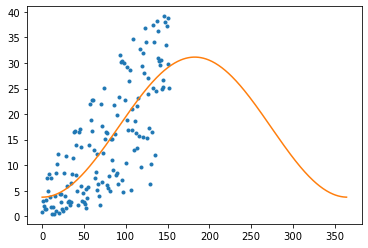

In [22]:
ind = produced['Produced']>0
ind = ind & produced['Date'].apply(lambda x: x.hour==0)
ind = ind & produced['Date'].apply(lambda x: x.year==2023)
fitting_set_prod = produced.loc[ind].copy()


fitting_set_prod['day_of_year']=(fitting_set_prod['Date']-fitting_set_prod['Year'].apply(lambda x: datetime(x,1,1)))/timedelta(days=1)


def f_production(d,params):
    a=params[0]
    b=params[1]
    #c=params[2]
    c=0
    return a+b*np.sin(np.pi*(d-c)/365)**2

def f_cum_produce(d,params):
    dd = np.arange(1,361)
    prod = interp1d(dd,f_production(dd,params).cumsum())(d)
    return prod
    

f_tar = lambda params: np.sum((f_production(fitting_set_prod['day_of_year'].values,params)-fitting_set_prod['Produced'].values)**2)

#f_tar = lambda params: np.sum((f_production(fitting_set['day_of_year'].values,params).cumsum()-fitting_set['Produced'].values.cumsum())**2)


sol = minimize(f_tar,[0,10],bounds=((0,1000),(0,1000)))

params_production = sol.x.copy()

plt.plot(fitting_set_prod['day_of_year'],fitting_set_prod['Produced'],'.')
plt.plot(np.arange(365),f_production(np.arange(365),sol.x))

fitting_set_prod['Produced'].sum(),f_production(fitting_set_prod['day_of_year'].values,sol.x).sum()
sol

      fun: 8364.902269742412
 hess_inv: array([[1.18688740e-06, 7.65044878e-08],
       [7.65044878e-08, 5.10285153e-09]])
      jac: array([-0.00134277,  0.03735352])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 189
      nit: 8
     njev: 59
   status: 2
  success: False
        x: array([19.69287179,  8.11933364])

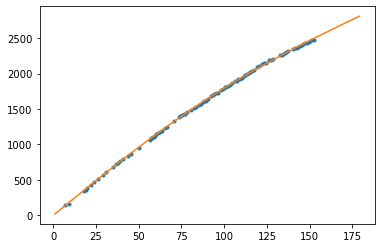

In [23]:
fitting_set_use = meter[['Date','Meter']].copy()
#ind = fitting_set['Date'].apply(lambda x:x.hour>=0)
ind = fitting_set_use['Date'].apply(lambda x:x.year==2023)
fitting_set_use=fitting_set_use.loc[ind]

fitting_set_use['day_of_year']=(fitting_set_use['Date']-fitting_set_use['Date'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)

def f_use(d,params):
    a=params[0]
    b=params[1]
    #c=params[2]
    c=0
    #return a-b*((d-180)/365)**2
    return a-b*np.sin(np.pi*(d-c)/365)**2

fitting_set_use['Net Used'] = fitting_set_use['Meter'].diff()

fitting_set_use

df_ = produced.copy().dropna()
df_['Cum Produced'] = df_['Produced'].cumsum()
d0 = datetime(2023,1,1)

cum_prod = interp1d(((df_['Date']-d0)/timedelta(days=1)).values,df_['Cum Produced'].values)
fitting_set_use['cum_prod']=cum_prod(((fitting_set_use['Date']-d0)/timedelta(days=1)).values)
fitting_set_use['prod'] = fitting_set_use['cum_prod'].diff()
fitting_set_use['used'] =fitting_set_use['prod']+fitting_set_use['Net Used']
fitting_set_use['cum_used']=fitting_set_use['used'].cumsum()
fitting_set_use=fitting_set_use.dropna()
fitting_set_use

def f_cum_use(d,params):
    dd = np.arange(1,361)
    used = interp1d(dd,f_use(dd,params).cumsum())(d)
    return used


f_tar = lambda params: np.sum((f_cum_use(fitting_set_use['day_of_year'].values,params)-fitting_set_use['cum_used'].values)**2)
#f_tar = lambda params: np.sum(np.diff((interp1d(np.arange(1,366),f_use(np.arange(1,366),params))(fitting_set['day_of_year'].values))-fitting_set['used'].values)**2)
sol = minimize(f_tar,[0,10])

plt.plot(fitting_set_use['day_of_year'].values,fitting_set_use['cum_used'].values,'.')
xx = np.arange(1,180)
#xx = fitting_set['day_of_year'].values
plt.plot(xx,f_cum_use(xx,sol.x))
#plt.plot(fitting_set['day_of_year'].values,fitting_set['used'].values,'.')
params_use=sol.x.copy()

sol

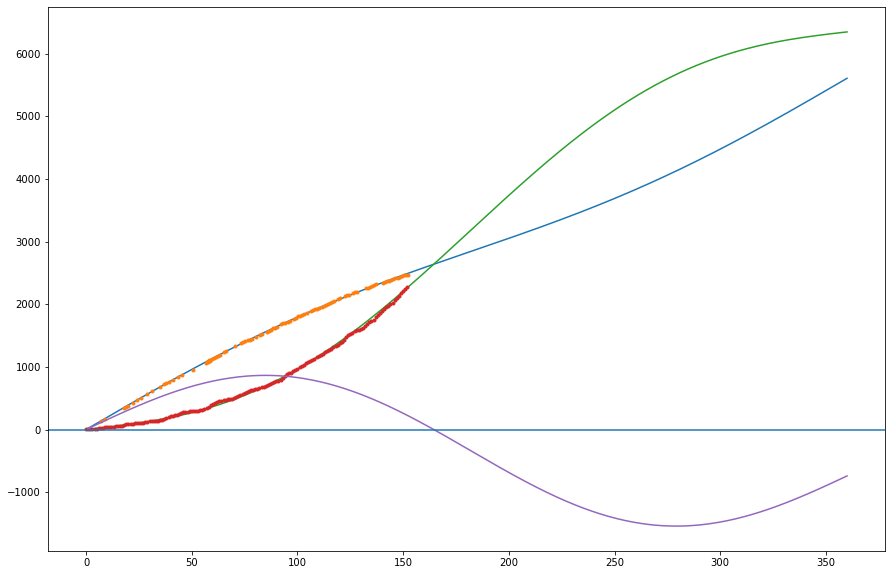

In [27]:
plt.figure(figsize=(15,10))
xx = np.arange(1,361)
#xx = fitting_set['day_of_year'].values
plt.plot(xx,f_cum_use(xx,params_use))
plt.plot(fitting_set_use['day_of_year'].values,fitting_set_use['cum_used'].values,'.')
plt.plot(xx,f_cum_produce(xx,params_production))

plt.plot(fitting_set_prod['day_of_year'].values,fitting_set_prod['Produced'].values.cumsum(),'.')

plt.plot(xx,f_cum_use(xx,params_use)-f_cum_produce(xx,params_production))
plt.axhline(y=0)


In [11]:
meter.head(12)

,Date,Meter,Date
0,2022-12-22 00:00:00+00:00,28620.0,2022-12-22
1,2023-01-01 00:00:00+00:00,28781.0,2023-01-01
2,2023-01-08 00:00:00+00:00,28896.0,2023-01-08
3,2023-01-10 00:00:00+00:00,28907.0,2023-01-10
4,2023-01-19 00:00:00+00:00,29052.0,2023-01-19
5,2023-01-20 00:00:00+00:00,29058.0,2023-01-20
6,2023-01-21 00:00:00+00:00,29079.0,2023-01-21
7,2023-01-23 00:00:00+00:00,29113.0,2023-01-23
8,2023-01-25 00:00:00+00:00,29148.0,2023-01-25
9,2023-01-27 00:00:00+00:00,29182.0,2023-01-27


In [12]:
per_month=produced[['Year','Month','Produced','Net Used','Total Used']].groupby(['Year','Month']).sum()
per_month

Produced    Net Used  Total Used
Year Month                                    
2022 12      19.339000  193.200000  212.539000
2023 1      131.255000  476.600000  607.855000
     2      236.186000  265.221220  501.407220
     3      393.108000  134.637749  527.745749
     4      596.593373 -137.927121  458.666252
     5      847.481000 -472.582606  374.898394
     6       72.307845  -53.394901   18.912945

Text(0.5, 1.0, 'Use')

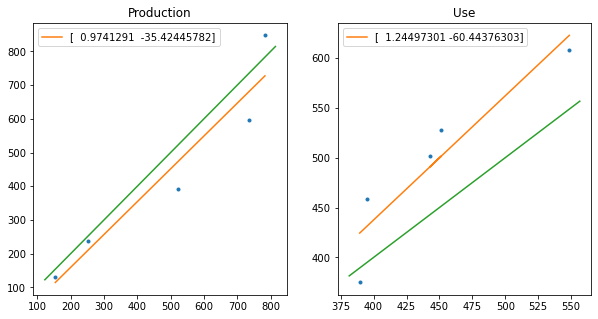

In [13]:
i=5

total_used = per_month.loc[2023,:].loc[:i]['Total Used'].values
produced_ = per_month.loc[2023,:].loc[:i]['Produced'].values

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(estimate[:produced_.size],produced_,'.')
poly_produce = np.polyfit(estimate[:produced_.size],produced_,1)
plt.plot(estimate[:produced_.size],np.polyval(poly_produce,estimate[:produced_.size]),label=poly_produce)
xx = plt.gca().get_xlim()
plt.plot(xx,xx)
plt.title('Production')
plt.legend()

plt.subplot(1,2,2)

plt.plot(used_2022[:total_used.size],total_used,'.')
poly_use = np.polyfit(used_2022[:total_used.size],total_used,1)
plt.plot(used_2022[:total_used.size],np.polyval(poly_use,used_2022[:total_used.size]),label=poly_use)
xx = plt.gca().get_xlim()
plt.plot(xx,xx)
plt.legend()
plt.title('Use')

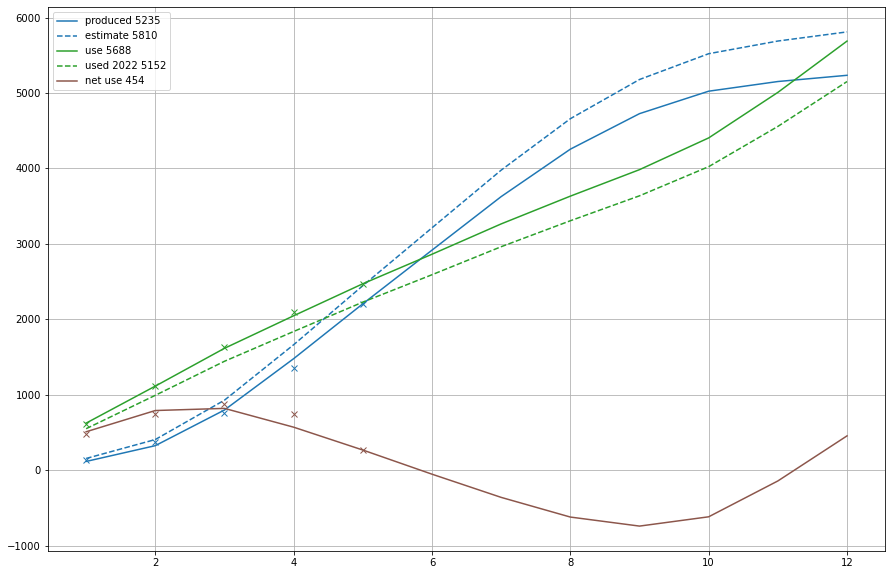

In [14]:
plt.figure(figsize=(15,10))
x=np.arange(12)+1
xx = np.arange(i)+1



proj_prod = np.polyval(poly_produce,estimate)
plt.plot(x,proj_prod.cumsum(),label=f'produced {proj_prod.sum():0.0f}',color='C0')
plt.plot(xx,produced_.cumsum(),'x',color='C0')
plt.plot(x,estimate.cumsum(),label=f'estimate {estimate.sum():0.0f}',color='C0',ls='--')

proj_use=np.polyval(poly_use,used_2022)
plt.plot(x,proj_use.cumsum(),label=f'use {proj_use.sum():0.0f}',color='C2')
plt.plot(xx,total_used.cumsum(),'x',color='C2')
plt.plot(x,used_2022.cumsum(),label=f'used 2022 {used_2022.sum():0.0f}',color='C2',ls='--')

plt.plot(x,(proj_use-proj_prod).cumsum(),label=f'net use {(proj_use-proj_prod).sum():0.0f}',color='C5')
plt.plot(xx,(total_used-produced_).cumsum(),'x',color='C5')

plt.grid(True)
plt.legend()

In [15]:
produced[['Year','Month','Produced','Net Used','Total Used']].groupby(['Year','Month']).mean()

Produced   Net Used  Total Used
Year Month                                  
2022 12      1.611583  16.100000   17.711583
2023 1       4.234032  15.374194   19.608226
     2       8.435214   9.472186   17.907401
     3      12.680903   4.343153   17.024056
     4      19.886446  -4.597571   15.288875
     5      27.338097 -15.244600   12.093497
     6      24.102615 -17.798300    6.304315

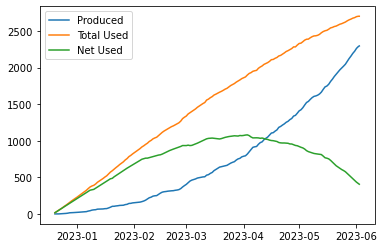

In [16]:
x=produced['Date']

for col in ['Produced','Total Used','Net Used']:
    plt.plot(x,produced[col].cumsum(),label=col)
plt.legend()


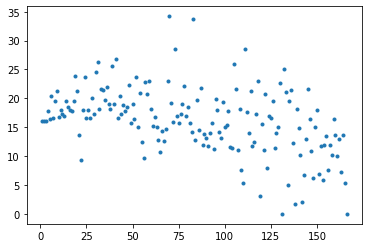

In [17]:
#plt.hist(produced['Total Used'],20);
#plt.hist(produced['Produced'],50);
#plt.plot(produced['Meter'])
plt.plot(produced['Total Used'],'.')